In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import warnings
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                           precision_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay)

warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
# Common Data Loading Functions
import csv
from io import StringIO
from sklearn.preprocessing import OneHotEncoder

def load_arff_data(dataset_path):
    """Load ARFF data into pandas DataFrame with robust CSV parsing"""
    with open(dataset_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    attributes = []
    data_start = None
    i = 0
    
    # Parse attributes, handling multi-line declarations
    while i < len(lines):
        line = lines[i].strip()
        
        if line.upper().startswith('@ATTRIBUTE'):
            parts = line.split()
            if len(parts) >= 3:
                attr_name = parts[1]
                attributes.append(attr_name)
                
                # Handle multi-line attribute declarations with braces
                if '{' in line and line.count('{') > line.count('}'):
                    i += 1
                    while i < len(lines) and '}' not in lines[i]:
                        i += 1
                    if i < len(lines) and '}' in lines[i]:
                        i += 1
                    continue
        elif line.upper().startswith('@DATA'):
            data_start = i + 1
            break
        
        i += 1
    
    if data_start is None:
        raise ValueError("Could not find @DATA section in ARFF file")
    
    # Collect data lines
    data_lines = []
    for i in range(data_start, len(lines)):
        line = lines[i].strip()
        if line and not line.startswith('%'):
            data_lines.append(line)
    
    # Parse data using CSV reader with single quotes
    data_rows = []
    problematic_lines = 0
    
    for line_num, line in enumerate(data_lines):
        try:
            csv_file = StringIO(line)
            csv_reader = csv.reader(csv_file, delimiter=',', quotechar="'", skipinitialspace=True)
            row = next(csv_reader)
            row = [field.strip() for field in row]
            
            if len(row) == len(attributes):
                data_rows.append(row)
            else:
                problematic_lines += 1
                    
        except Exception as e:
            problematic_lines += 1
    
    if len(data_rows) == 0:
        raise ValueError("No valid data rows found")
    
    df = pd.DataFrame(data_rows, columns=attributes)
    return df

def preprocess_data(df, target_column, sample_size=1000000):
    """Common preprocessing function for all models"""
    df_working = df.copy()
    
    # Sample data if needed using stratified sampling
    if sample_size < len(df_working):
        from sklearn.model_selection import train_test_split
        # Use stratified sampling to maintain class distribution
        df_working, _ = train_test_split(
            df_working, 
            train_size=sample_size, 
            random_state=42, 
            stratify=df_working[target_column]
        )
    
    # Select features
    exclude_cols = [target_column, 'seqid', 'date_of_stop', 'time_of_stop', 'geolocation', 'driver_license', 'registration']
    feature_columns = [col for col in df_working.columns if col not in exclude_cols]
    
    X = df_working[feature_columns].copy()
    y = df_working[target_column].copy()
    
    # Encode target
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)
    
    # Process features
    categorical_features = []
    numerical_features = []
    label_encoders = {}
    
    for col in feature_columns:
        if X[col].dtype == 'object':
            categorical_features.append(col)
        else:
            try:
                numeric_series = pd.to_numeric(X[col], errors='coerce')
                if numeric_series.notna().sum() / len(numeric_series) > 0.8:
                    X[col] = numeric_series
                    numerical_features.append(col)
                else:
                    categorical_features.append(col)
            except:
                categorical_features.append(col)
    
    # Handle missing values
    for col in categorical_features:
        X[col] = X[col].fillna('Unknown')
    
    if numerical_features:
        numerical_imputer = SimpleImputer(strategy='median')
        X[numerical_features] = numerical_imputer.fit_transform(X[numerical_features])
    
    # Encode categorical features
    for col in categorical_features:
        label_encoders[col] = LabelEncoder()
        X[col] = label_encoders[col].fit_transform(X[col])
    
    return X.values, y_encoded, target_encoder, label_encoders

print("Data loading and preprocessing functions ready!")

Data loading and preprocessing functions ready with One-Hot Encoding!


In [3]:
# Load Dataset
print("Loading Traffic Violation Dataset...")
dataset_path = "dataset.arff"
df = load_arff_data(dataset_path)

print(f"Dataset loaded successfully: {len(df)} rows, {len(df.columns)} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few columns:", df.columns[:10].tolist())
print("Target column 'violation_type' available:", 'violation_type' in df.columns)
print("\nSample of first few rows:")
print(df.head(3).to_string())

Loading Traffic Violation Dataset...
Dataset loaded successfully: 1578085 rows, 43 columns
Dataset loaded successfully: 1578085 rows, 43 columns
Memory usage: 3749.13 MB

First few columns: ['seqid', 'date_of_stop', 'time_of_stop', 'agency', 'subagency', 'description', 'location', 'latitude', 'longitude', 'accident']
Target column 'violation_type' available: True

Sample of first few rows:
                                  seqid date_of_stop time_of_stop agency                subagency                                                                 description                   location            latitude          longitude accident belts personal_injury property_damage fatal commercial_license hazmat commercial_vehicle alcohol work_zone search_conducted search_disposition search_outcome search_reason search_reason_for_stop search_type search_arrest_reason state            vehicletype  year    make   model   color violation_type      charge                 article contributed_to_accid

In [4]:
# EXPLORATORY DATA ANALYSIS - Basic Statistics
print("="*60)
print("BASIC DATASET STATISTICS")
print("="*60)

# Dataset shape and info
print(f"Total Records: {len(df):,}")
print(f"Total Features: {len(df.columns)}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Missing values analysis
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

print(f"\nMissing Values:")
print(f"Total Missing: {missing_data.sum():,}")
print(f"Columns with Missing: {(missing_data > 0).sum()}")

if missing_data.sum() > 0:
    print("\nTop columns with missing values:")
    missing_summary = pd.DataFrame({
        'Missing_Count': missing_data,
        'Missing_Percentage': missing_percentage
    }).sort_values('Missing_Count', ascending=False)
    print(missing_summary[missing_summary['Missing_Count'] > 0].head(10))
else:
    print("No missing values found")

# Data types
dtype_counts = df.dtypes.value_counts()
print(f"\nData Types:")
for dtype, count in dtype_counts.items():
    print(f"  {dtype}: {count} columns")

BASIC DATASET STATISTICS
Total Records: 1,578,085
Total Features: 43
Memory Usage: 3749.13 MB
Memory Usage: 3749.13 MB

Missing Values:
Total Missing: 0
Columns with Missing: 0
No missing values found

Data Types:
  object: 43 columns

Missing Values:
Total Missing: 0
Columns with Missing: 0
No missing values found

Data Types:
  object: 43 columns


In [5]:
# TARGET VARIABLE ANALYSIS
print("="*60)
print("TARGET VARIABLE ANALYSIS")
print("="*60)

if 'violation_type' in df.columns:
    # Check if we have any data
    if len(df) == 0:
        print("Error: No data rows found in dataset")
        target_distribution = None
    else:
        # Value counts and distribution
        value_counts = df['violation_type'].value_counts()
        
        if len(value_counts) == 0:
            print("Error: No valid values found in violation_type column")
            print(f"Column info: {df['violation_type'].dtype}, Null count: {df['violation_type'].isnull().sum()}")
            print(f"Sample values: {df['violation_type'].head(10).tolist()}")
            target_distribution = None
        else:
            percentages = (value_counts / len(df)) * 100
            
            print("Violation Type Distribution:")
            for vtype, count in value_counts.items():
                percentage = percentages[vtype]
                print(f"  {vtype:<15}: {count:>8,} ({percentage:>5.1f}%)")
            
            print(f"\nTarget Analysis Summary:")
            print(f"Unique Classes: {df['violation_type'].nunique()}")
            print(f"Most Common: {value_counts.index[0]} ({value_counts.iloc[0]:,} records)")
            print(f"Least Common: {value_counts.index[-1]} ({value_counts.iloc[-1]:,} records)")
            
            # Store for later use
            target_distribution = {
                'distribution': {str(k): {'count': int(v), 'percentage': float(percentages[k])} 
                                for k, v in value_counts.items()},
                'unique_classes': int(df['violation_type'].nunique()),
                'most_common': value_counts.index[0],
                'least_common': value_counts.index[-1]
            }
else:
    print("Error: violation_type column not found")
    target_distribution = None

TARGET VARIABLE ANALYSIS
Violation Type Distribution:
  Citation       :  711,429 ( 45.1%)
  ESERO          :   75,974 (  4.8%)
  SERO           :      899 (  0.1%)

Target Analysis Summary:
Violation Type Distribution:
  Citation       :  711,429 ( 45.1%)
  ESERO          :   75,974 (  4.8%)
  SERO           :      899 (  0.1%)

Target Analysis Summary:
Unique Classes: 4
Most Common: Warning (789,783 records)
Least Common: SERO (899 records)
Unique Classes: 4
Most Common: Warning (789,783 records)
Least Common: SERO (899 records)


In [ ]:
# NUMERICAL AND CATEGORICAL FEATURES ANALYSIS
print("="*60)
print("FEATURE ANALYSIS")
print("="*60)

# Identify numerical and categorical columns
numerical_cols = []
categorical_cols = []

for col in df.columns:
    if df[col].dtype == 'object':
        categorical_cols.append(col)
    else:
        try:
            numeric_series = pd.to_numeric(df[col], errors='coerce')
            if numeric_series.notna().sum() / len(numeric_series) > 0.8:
                numerical_cols.append(col)
            else:
                categorical_cols.append(col)
        except:
            categorical_cols.append(col)

print(f"Numerical Features: {len(numerical_cols)}")
print(f"Categorical Features: {len(categorical_cols)}")

# Numerical features analysis
print(f"\nNumerical Features Analysis:")
numerical_analysis = {}

for col in numerical_cols[:40]:
    try:
        numeric_data = pd.to_numeric(df[col], errors='coerce').dropna()
        
        if len(numeric_data) > 0:
            stats_dict = {
                'count': int(len(numeric_data)),
                'mean': float(numeric_data.mean()),
                'median': float(numeric_data.median()),
                'std': float(numeric_data.std()),
                'variance': float(numeric_data.var()),
                'min': float(numeric_data.min()),
                'max': float(numeric_data.max()),
                'skewness': float(stats.skew(numeric_data)),
                'kurtosis': float(stats.kurtosis(numeric_data))
            }
            
            numerical_analysis[col] = stats_dict
            
            print(f"\n{col}:")
            print(f"  Mean: {stats_dict['mean']:.2f}, Median: {stats_dict['median']:.2f}")
            print(f"  Std: {stats_dict['std']:.2f}, Skewness: {stats_dict['skewness']:.3f}")
            
    except Exception as e:
        print(f"Error processing {col}: {str(e)}")

# Categorical features analysis
print(f"\nCategorical Features Analysis:")
categorical_analysis = {}

for col in categorical_cols[:40]:
    unique_count = df[col].nunique()
    top_values = df[col].value_counts().head(3)
    
    analysis = {
        'unique_count': int(unique_count),
        'top_values': {str(k): int(v) for k, v in top_values.items()}
    }
    
    categorical_analysis[col] = analysis
    
    print(f"\n{col}: {unique_count} unique values")
    if unique_count <= 20:
        print("  Top values:")
        for value, count in top_values.items():
            percentage = (count / len(df)) * 100
            print(f"    {str(value):<20}: {count:>6,} ({percentage:>5.1f}%)")

FEATURE ANALYSIS
Numerical Features: 0
Categorical Features: 43

Numerical Features Analysis (first 5):

Categorical Features Analysis (first 5):

seqid: 895088 unique values

seqid: 895088 unique values

date_of_stop: 2810 unique values

date_of_stop: 2810 unique values

time_of_stop: 1440 unique values

time_of_stop: 1440 unique values

agency: 1 unique values
  Top values:
    MCP                 : 1,578,085 (100.0%)

agency: 1 unique values
  Top values:
    MCP                 : 1,578,085 (100.0%)

subagency: 9 unique values
  Top values:
    4th District, Wheaton: 385,876 ( 24.5%)
    3rd District, Silver Spring: 308,089 ( 19.5%)
    2nd District, Bethesda: 257,400 ( 16.3%)

subagency: 9 unique values
  Top values:
    4th District, Wheaton: 385,876 ( 24.5%)
    3rd District, Silver Spring: 308,089 ( 19.5%)
    2nd District, Bethesda: 257,400 ( 16.3%)


CREATING EDA VISUALIZATIONS
Using 50,000 samples for visualization
Using 50,000 samples for visualization


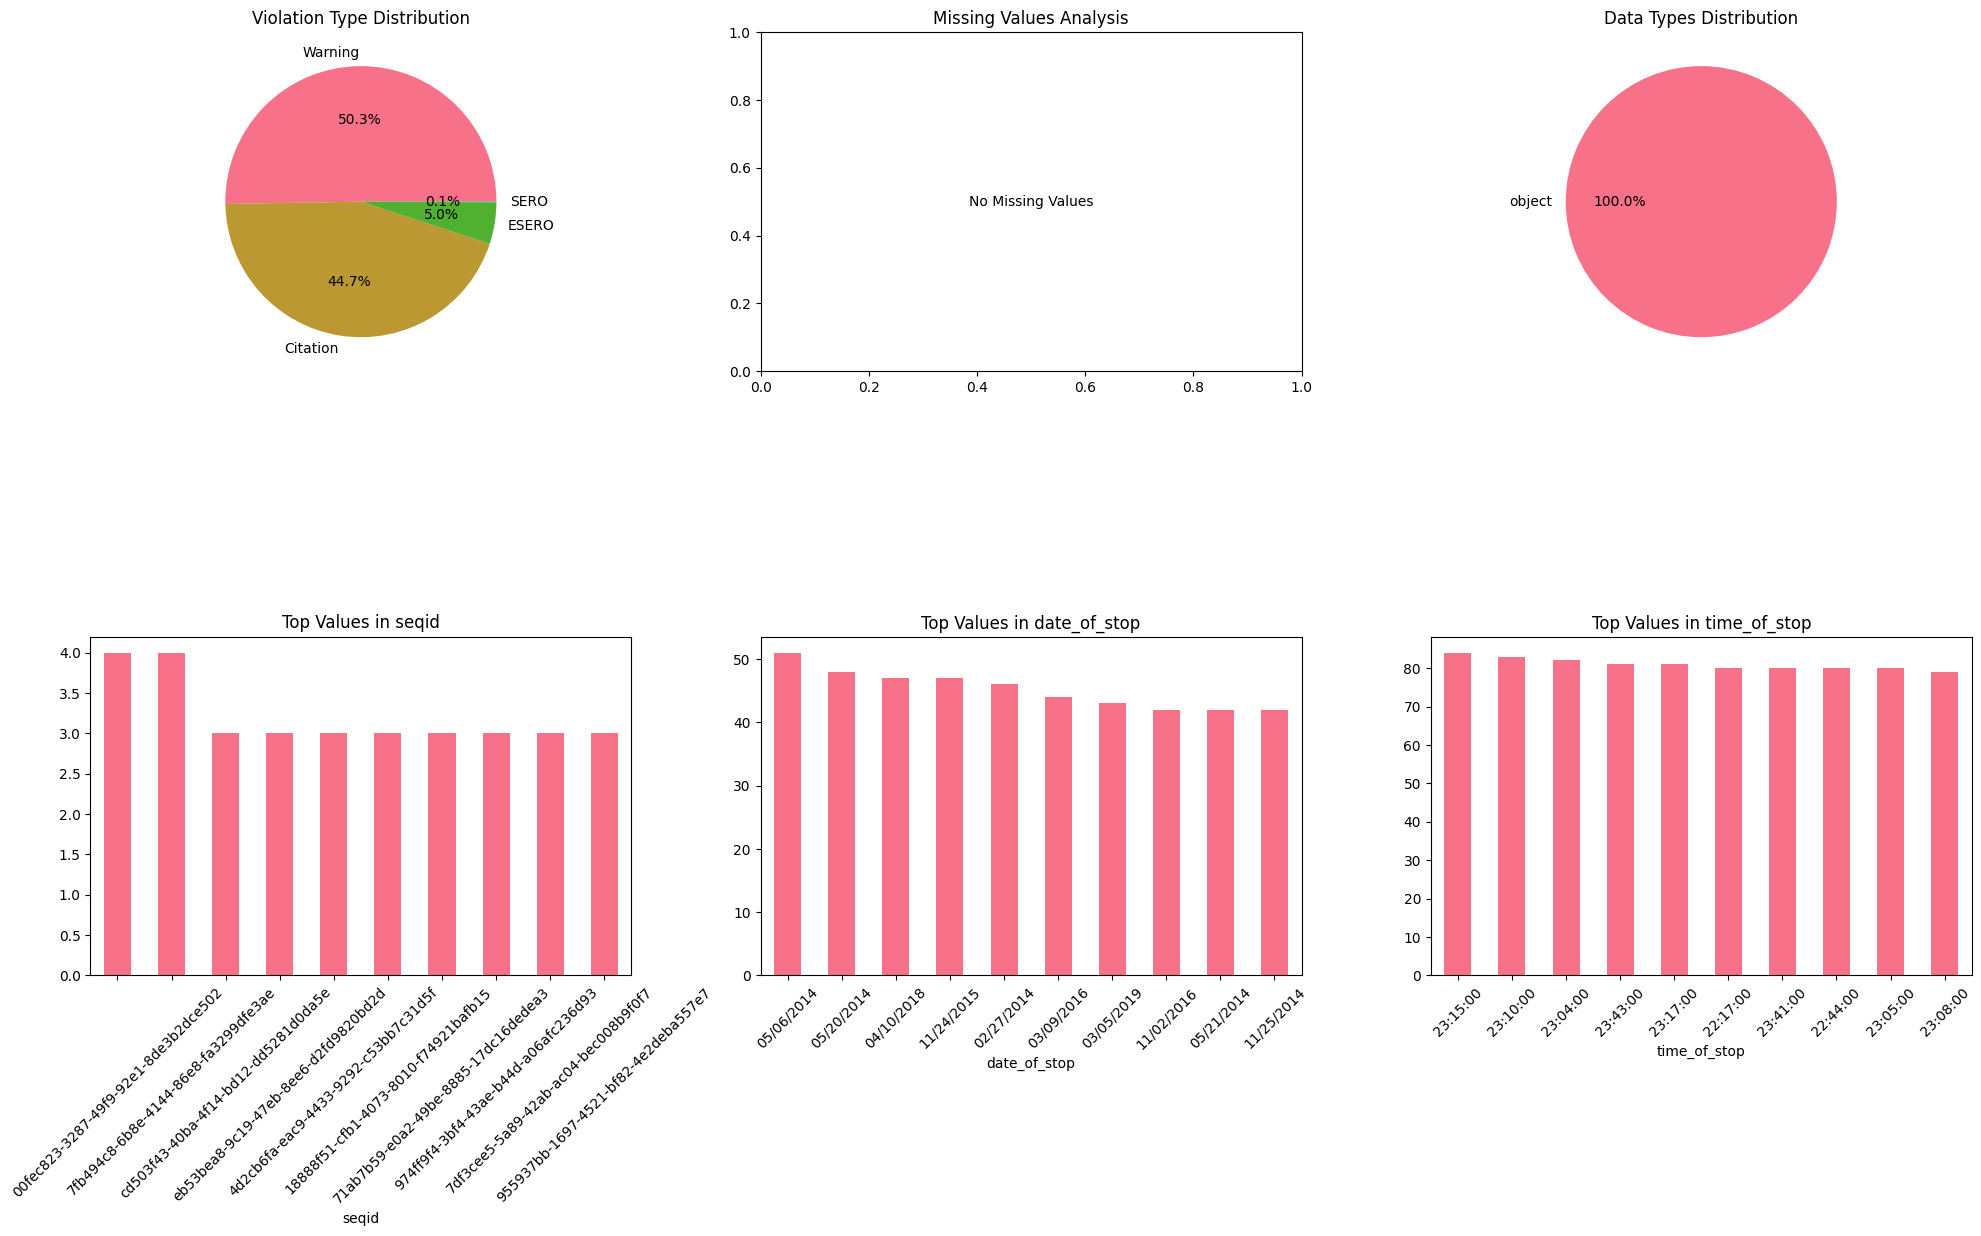

EDA visualizations completed!


In [ ]:
# Exploratory Data Analysis Visualization
print("="*60)
print("CREATING EDA VISUALIZATIONS")
print("="*60)

# Sample data for visualization performance
sample_size = 50000
if len(df) > sample_size:
    df_viz = df.sample(n=sample_size, random_state=42)
    print(f"Using {sample_size:,} samples for visualization")
else:
    df_viz = df

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 16))

# 1. Target variable distribution
plt.subplot(3, 3, 1)
if 'violation_type' in df_viz.columns:
    violation_counts = df_viz['violation_type'].value_counts()
    plt.pie(violation_counts.values, labels=violation_counts.index, autopct='%1.1f%%')
    plt.title('Violation Type Distribution')

# 2. Missing values bar chart
plt.subplot(3, 3, 2)
missing_data = df_viz.isnull().sum().head(15)
if missing_data.sum() > 0:
    missing_data[missing_data > 0].plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Missing Values Analysis')

# 3. Data types distribution
plt.subplot(3, 3, 3)
dtype_counts = df_viz.dtypes.value_counts()
plt.pie(dtype_counts.values, labels=dtype_counts.index, autopct='%1.1f%%')
plt.title('Data Types Distribution')

# 4-6. Histograms for numerical features
plot_idx = 4
for i, col in enumerate(numerical_cols[:3]):
    plt.subplot(3, 3, plot_idx)
    try:
        numeric_data = pd.to_numeric(df_viz[col], errors='coerce').dropna()
        if len(numeric_data) > 0:
            plt.hist(numeric_data, bins=30, alpha=0.7, edgecolor='black')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
    except:
        plt.text(0.5, 0.5, f'Cannot plot {col}', ha='center', va='center', transform=plt.gca().transAxes)
    plot_idx += 1

# 7-9. Top categorical feature distributions
for i, col in enumerate(categorical_cols[:3]):
    if plot_idx > 9:
        break
    plt.subplot(3, 3, plot_idx)
    
    try:
        top_values = df_viz[col].value_counts().head(10)
        if len(top_values) > 0:
            top_values.plot(kind='bar')
            plt.title(f'Top Values in {col}')
            plt.xticks(rotation=45)
    except:
        plt.text(0.5, 0.5, f'Cannot plot {col}', ha='center', va='center', transform=plt.gca().transAxes)
    
    plot_idx += 1

plt.tight_layout()
plt.show()

print("EDA visualizations completed!")

In [ ]:
# PREPROCESSING SUMMARY DOCUMENTATION
print("="*60)
print("PREPROCESSING STEPS PERFORMED")
print("="*60)

preprocessing_info = {
    "data_loading": {
        "format": "ARFF",
        "parsing_method": "Custom CSV parser with quote handling",
        "encoding": "UTF-8"
    },
    "sampling": {
        "strategy": "Stratified random sampling",
        "sample_size": 200000,
        "random_state": 42
    },
    "feature_selection": {
        "excluded_columns": [
            "seqid", "date_of_stop", "time_of_stop", 
            "geolocation", "driver_license", "registration"
        ],
        "exclusion_reason": "Non-predictive or identifier columns"
    },
    "missing_value_treatment": {
        "categorical": "Mode imputation ('Unknown' for truly missing)",
        "numerical": "Median imputation"
    },
    "encoding": {
        "categorical_features": "Label Encoding",
        "target_variable": "Label Encoding"
    },
    "scaling": {
        "method": "StandardScaler (for KNN and Logistic Regression)",
        "reason": "Different feature scales require normalization"
    },
    "data_splitting": {
        "method": "Stratified train-test split",
        "test_size": 0.2,
        "random_state": 42
    }
}


# Store preprocessing info for later reference
print("\nPreprocessing information stored for model training.")

PREPROCESSING STEPS PERFORMED
1. Data Loading:
   - Format: ARFF with custom CSV parser
   - Handles quoted fields and special characters

2. Sampling Strategy:
   - Stratified random sampling (200K records)
   - Preserves target distribution

3. Feature Selection:
   - Excluded non-predictive columns:
     * seqid, date_of_stop, time_of_stop
     * geolocation, driver_license, registration

4. Missing Value Treatment:
   - Categorical: Mode imputation
   - Numerical: Median imputation

5. Encoding:
   - Categorical features: One-Hot Encoding
   - Target variable: Label Encoding

6. Feature Scaling:
   - StandardScaler for distance-based algorithms
   - Required for KNN and Logistic Regression

7. Data Splitting:
   - 80-20 stratified train-test split
   - Maintains class distribution

Preprocessing information stored for model training.


In [ ]:
# K-NEAREST NEIGHBORS CLASSIFICATION
print("="*60)
print("K-NEAREST NEIGHBORS CLASSIFICATION")
print("="*60)

# Preprocess data for KNN
X, y, target_encoder, label_encoders = preprocess_data(df, 'violation_type')

# Scale features for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use smaller sample for k optimization (much faster)
print("Finding optimal k value using smaller sample...")
k_sample_size = min(100000, len(X))  # Use 100K samples for k optimization
X_k_sample, _, y_k_sample, _ = train_test_split(
    X_scaled, y, 
    train_size=k_sample_size, 
    random_state=42, 
    stratify=y
)

k_values = range(3, 21, 2)
cv_scores = []

print(f"Testing k values on {k_sample_size:,} samples...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X_k_sample, y_k_sample, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"k={k}: {scores.mean():.4f}")

optimal_k = k_values[np.argmax(cv_scores)]
print(f"Optimal k: {optimal_k}")

# Split full dataset for final training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train KNN model with optimal k on full dataset
print("Training KNN model...")
knn_model = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')
knn_model.fit(X_train, y_train)

# Make predictions
y_test_pred_knn = knn_model.predict(X_test)

# Generate confusion matrix
knn_cm = confusion_matrix(y_test, y_test_pred_knn)
knn_cm_normalized = confusion_matrix(y_test, y_test_pred_knn, normalize='true')

# Calculate metrics
knn_accuracy = accuracy_score(y_test, y_test_pred_knn)
knn_f1_macro = f1_score(y_test, y_test_pred_knn, average='macro')
knn_f1_weighted = f1_score(y_test, y_test_pred_knn, average='weighted')
knn_recall_macro = recall_score(y_test, y_test_pred_knn, average='macro')
knn_recall_weighted = recall_score(y_test, y_test_pred_knn, average='weighted')
knn_precision_macro = precision_score(y_test, y_test_pred_knn, average='macro')
knn_precision_weighted = precision_score(y_test, y_test_pred_knn, average='weighted')
knn_mae = mean_absolute_error(y_test, y_test_pred_knn)

# Store results
knn_results = {
    'algorithm': 'K-Nearest Neighbors',
    'optimal_k': optimal_k,
    'sample_size': len(X),
    'test_size': len(X_test),
    'accuracy': knn_accuracy,
    'f1_macro': knn_f1_macro,
    'f1_weighted': knn_f1_weighted,
    'recall_macro': knn_recall_macro,
    'recall_weighted': knn_recall_weighted,
    'precision_macro': knn_precision_macro,
    'precision_weighted': knn_precision_weighted,
    'mae': knn_mae,
    'target_classes': target_encoder.classes_.tolist()
}

# Visualize confusion matrix
plt.figure(figsize=(15, 6))

# Plot unnormalized confusion matrix
plt.subplot(1, 2, 1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=knn_model.classes_)
disp1.plot(ax=plt.gca(), cmap='Blues', values_format='d')
plt.title('KNN Confusion Matrix')
plt.xticks(rotation=45, ha='right')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=knn_cm_normalized, display_labels=knn_model.classes_)
disp2.plot(ax=plt.gca(), cmap='Blues', values_format='.2f')
plt.title('KNN Confusion Matrix (Normalized)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"KNN Results:")
print("\nKNN Classification Results:")
print(f"Optimal K: {optimal_k}")
print(f"Accuracy: {knn_accuracy:.4f}")
print(f"F1-Score (Macro): {knn_f1_macro:.4f}")
print(f"Precision (Macro): {knn_precision_macro:.4f}")
print(f"Recall (Macro): {knn_recall_macro:.4f}")
print(f"MAE: {knn_mae:.4f}")

print("KNN model training completed!")

In [ ]:
# LOGISTIC REGRESSION CLASSIFICATION
print("="*60)
print("LOGISTIC REGRESSION CLASSIFICATION")
print("="*60)

# Preprocess data for Logistic Regression (reuse same preprocessing)
X_lr, y_lr, target_encoder_lr, label_encoders_lr = preprocess_data(df, 'violation_type')

# Scale features for Logistic Regression
scaler_lr = StandardScaler()
X_lr_scaled = scaler_lr.fit_transform(X_lr)

# Split data
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr_scaled, y_lr, test_size=0.2, random_state=42, stratify=y_lr)

print(f"Training set: {X_train_lr.shape[0]} samples")
print(f"Test set: {X_test_lr.shape[0]} samples")

# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
lr_model.fit(X_train_lr, y_train_lr)

# Make predictions
y_test_pred_lr = lr_model.predict(X_test_lr)

# Generate confusion matrix
lr_cm = confusion_matrix(y_test_lr, y_test_pred_lr)
lr_cm_normalized = confusion_matrix(y_test_lr, y_test_pred_lr, normalize='true')

# Calculate metrics
lr_accuracy = accuracy_score(y_test_lr, y_test_pred_lr)
lr_f1_macro = f1_score(y_test_lr, y_test_pred_lr, average='macro')
lr_f1_weighted = f1_score(y_test_lr, y_test_pred_lr, average='weighted')
lr_recall_macro = recall_score(y_test_lr, y_test_pred_lr, average='macro')
lr_recall_weighted = recall_score(y_test_lr, y_test_pred_lr, average='weighted')
lr_precision_macro = precision_score(y_test_lr, y_test_pred_lr, average='macro')
lr_precision_weighted = precision_score(y_test_lr, y_test_pred_lr, average='weighted')
lr_mae = mean_absolute_error(y_test_lr, y_test_pred_lr)

# Store results
lr_results = {
    'algorithm': 'Logistic Regression',
    'sample_size': len(X_lr),
    'test_size': len(X_test_lr),
    'accuracy': lr_accuracy,
    'f1_macro': lr_f1_macro,
    'f1_weighted': lr_f1_weighted,
    'recall_macro': lr_recall_macro,
    'recall_weighted': lr_recall_weighted,
    'precision_macro': lr_precision_macro,
    'precision_weighted': lr_precision_weighted,
    'mae': lr_mae,
    'target_classes': target_encoder_lr.classes_.tolist()
}

print("\nLogistic Regression Classification Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1-Score (Macro): {lr_f1_macro:.4f}")
print(f"Precision (Macro): {lr_precision_macro:.4f}")
print(f"Recall (Macro): {lr_recall_macro:.4f}")
print(f"MAE: {lr_mae:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(15, 6))

# Plot unnormalized confusion matrix
plt.subplot(1, 2, 1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr_model.classes_)
disp1.plot(ax=plt.gca(), cmap='Greens', values_format='d')
plt.title('Logistic Regression Confusion Matrix')
plt.xticks(rotation=45, ha='right')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=lr_cm_normalized, display_labels=lr_model.classes_)
disp2.plot(ax=plt.gca(), cmap='Greens', values_format='.2f')
plt.title('Logistic Regression Confusion Matrix (Normalized)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Logistic Regression model training completed!")

LOGISTIC REGRESSION CLASSIFICATION


MemoryError: Unable to allocate 485. GiB for an array with shape (200000, 325426) and data type float64

In [ ]:
# RANDOM FOREST CLASSIFICATION
print("="*60)
print("RANDOM FOREST CLASSIFICATION")
print("="*60)

# Preprocess data for Random Forest (no scaling needed)
X_rf, y_rf, target_encoder_rf, label_encoders_rf = preprocess_data(df, 'violation_type')

# Split data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf)

print(f"Training set: {X_train_rf.shape[0]} samples")
print(f"Test set: {X_test_rf.shape[0]} samples")

# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions
y_test_pred_rf = rf_model.predict(X_test_rf)

# Generate confusion matrix
rf_cm = confusion_matrix(y_test_rf, y_test_pred_rf)
rf_cm_normalized = confusion_matrix(y_test_rf, y_test_pred_rf, normalize='true')

# Calculate metrics
rf_accuracy = accuracy_score(y_test_rf, y_test_pred_rf)
rf_f1_macro = f1_score(y_test_rf, y_test_pred_rf, average='macro')
rf_f1_weighted = f1_score(y_test_rf, y_test_pred_rf, average='weighted')
rf_recall_macro = recall_score(y_test_rf, y_test_pred_rf, average='macro')
rf_recall_weighted = recall_score(y_test_rf, y_test_pred_rf, average='weighted')
rf_precision_macro = precision_score(y_test_rf, y_test_pred_rf, average='macro')
rf_precision_weighted = precision_score(y_test_rf, y_test_pred_rf, average='weighted')
rf_mae = mean_absolute_error(y_test_rf, y_test_pred_rf)

# Store results
rf_results = {
    'algorithm': 'Random Forest',
    'n_estimators': 100,
    'sample_size': len(X_rf),
    'test_size': len(X_test_rf),
    'accuracy': rf_accuracy,
    'f1_macro': rf_f1_macro,
    'f1_weighted': rf_f1_weighted,
    'recall_macro': rf_recall_macro,
    'recall_weighted': rf_recall_weighted,
    'precision_macro': rf_precision_macro,
    'precision_weighted': rf_precision_weighted,
    'mae': rf_mae,
    'target_classes': target_encoder_rf.classes_.tolist(),
    'feature_importance': rf_model.feature_importances_.tolist()
}

print("\nRandom Forest Classification Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1-Score (Macro): {rf_f1_macro:.4f}")
print(f"Precision (Macro): {rf_precision_macro:.4f}")
print(f"Recall (Macro): {rf_recall_macro:.4f}")
print(f"MAE: {rf_mae:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(15, 6))

# Plot unnormalized confusion matrix
plt.subplot(1, 2, 1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_model.classes_)
disp1.plot(ax=plt.gca(), cmap='Oranges', values_format='d')
plt.title('Random Forest Confusion Matrix')
plt.xticks(rotation=45, ha='right')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=rf_cm_normalized, display_labels=rf_model.classes_)
disp2.plot(ax=plt.gca(), cmap='Oranges', values_format='.2f')
plt.title('Random Forest Confusion Matrix (Normalized)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Random Forest model training completed!")

In [ ]:
# CONSOLIDATE ALL MODEL RESULTS
print("="*60)
print("CONSOLIDATING MODEL RESULTS")
print("="*60)

# Consolidate all results
all_results = {
    'knn': knn_results,
    'logistic_regression': lr_results,
    'random_forest': rf_results,
    'metadata': {
        'dataset': dataset_path,
        'target_column': 'violation_type',
        'timestamp': datetime.now().isoformat(),
        'sample_size': 200000,
        'test_split': 0.2
    }
}

# Save results to file
with open('all_model_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print("Model results saved to 'all_model_results.json'")

# Quick summary comparison
print("\n" + "="*60)
print("QUICK PERFORMANCE SUMMARY")
print("="*60)

print(f"{'Model':<20} {'Accuracy':<10} {'F1-Macro':<10} {'MAE':<10}")
print("-" * 50)

models_data = [
    ('KNN', knn_results),
    ('Logistic Regression', lr_results),
    ('Random Forest', rf_results)
]

for name, results in models_data:
    print(f"{name:<20} {results['accuracy']:<10.4f} {results['f1_macro']:<10.4f} {results['mae']:<10.4f}")

print("\nAll model training completed successfully!")

In [ ]:
# MODEL PERFORMANCE COMPARISON TABLE
print("="*80)
print("MODEL PERFORMANCE COMPARISON TABLE")
print("="*80)

# Create comprehensive comparison DataFrame
comparison_data = []

for model_name, model_results in all_results.items():
    if model_name == 'metadata':
        continue
        
    row = {
        'Algorithm': model_results.get('algorithm', model_name),
        'Accuracy': model_results.get('accuracy', 0),
        'F1-Score (Macro)': model_results.get('f1_macro', 0),
        'F1-Score (Weighted)': model_results.get('f1_weighted', 0),
        'Precision (Macro)': model_results.get('precision_macro', 0),
        'Precision (Weighted)': model_results.get('precision_weighted', 0),
        'Recall (Macro)': model_results.get('recall_macro', 0),
        'Recall (Weighted)': model_results.get('recall_weighted', 0),
        'MAE': model_results.get('mae', 0),
        'Sample Size': model_results.get('sample_size', 0),
        'Test Size': model_results.get('test_size', 0)
    }
    comparison_data.append(row)

# Create DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Format numerical columns to 4 decimal places
numeric_cols = ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)', 
               'Precision (Macro)', 'Precision (Weighted)', 
               'Recall (Macro)', 'Recall (Weighted)', 'MAE']

for col in numeric_cols:
    if col in df_comparison.columns:
        df_comparison[col] = df_comparison[col].round(4)

print("Performance Metrics Comparison:")
print("-" * 100)
print(df_comparison.to_string(index=False))

# Find best performing model for each metric
print("\n" + "="*80)
print("BEST PERFORMING MODELS BY METRIC")
print("="*80)

for metric in numeric_cols[:-1]:  # Exclude MAE (lower is better)
    if metric in df_comparison.columns:
        best_idx = df_comparison[metric].idxmax()
        best_model = df_comparison.loc[best_idx, 'Algorithm']
        best_score = df_comparison.loc[best_idx, metric]
        print(f"{metric:<25}: {best_model:<20} ({best_score:.4f})")

# MAE - lower is better
if 'MAE' in df_comparison.columns:
    best_idx = df_comparison['MAE'].idxmin()
    best_model = df_comparison.loc[best_idx, 'Algorithm']
    best_score = df_comparison.loc[best_idx, 'MAE']
    print(f"{'MAE (Lower is Better)':<25}: {best_model:<20} ({best_score:.4f})")

print("\nComparison table analysis completed!")

In [ ]:
# MODEL COMPARISON VISUALIZATIONS
print("="*80)
print("CREATING COMPARISON VISUALIZATIONS")
print("="*80)

# Extract data for visualization
models = []
metrics_data = {
    'Accuracy': [],
    'F1-Score (Macro)': [],
    'Precision (Macro)': [],
    'Recall (Macro)': [],
    'MAE': []
}

for model_name, model_results in all_results.items():
    if model_name == 'metadata':
        continue
    
    models.append(model_results.get('algorithm', model_name))
    metrics_data['Accuracy'].append(model_results.get('accuracy', 0))
    metrics_data['F1-Score (Macro)'].append(model_results.get('f1_macro', 0))
    metrics_data['Precision (Macro)'].append(model_results.get('precision_macro', 0))
    metrics_data['Recall (Macro)'].append(model_results.get('recall_macro', 0))
    metrics_data['MAE'].append(model_results.get('mae', 0))

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

colors = ['skyblue', 'lightcoral', 'lightgreen']

# 1. Accuracy Comparison
axes[0, 0].bar(models, metrics_data['Accuracy'], color=colors)
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(metrics_data['Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 2. F1-Score Comparison
axes[0, 1].bar(models, metrics_data['F1-Score (Macro)'], color=colors)
axes[0, 1].set_title('F1-Score (Macro) Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate(metrics_data['F1-Score (Macro)']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 3. Precision Comparison
axes[0, 2].bar(models, metrics_data['Precision (Macro)'], color=colors)
axes[0, 2].set_title('Precision (Macro) Comparison')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_ylim(0, 1)
for i, v in enumerate(metrics_data['Precision (Macro)']):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 4. Recall Comparison
axes[1, 0].bar(models, metrics_data['Recall (Macro)'], color=colors)
axes[1, 0].set_title('Recall (Macro) Comparison')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim(0, 1)
for i, v in enumerate(metrics_data['Recall (Macro)']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 5. MAE Comparison (Lower is better)
axes[1, 1].bar(models, metrics_data['MAE'], color=colors)
axes[1, 1].set_title('Mean Absolute Error (Lower is Better)')
axes[1, 1].set_ylabel('MAE')
for i, v in enumerate(metrics_data['MAE']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 6. Radar Chart for All Metrics
angles = np.linspace(0, 2 * np.pi, 4, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Complete the circle

ax_radar = plt.subplot(2, 3, 6, projection='polar')
ax_radar.set_theta_offset(np.pi / 2)
ax_radar.set_theta_direction(-1)

metric_labels = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

for i, model in enumerate(models):
    values = [
        metrics_data['Accuracy'][i],
        metrics_data['F1-Score (Macro)'][i],
        metrics_data['Precision (Macro)'][i],
        metrics_data['Recall (Macro)'][i]
    ]
    values += [values[0]]  # Complete the circle
    
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax_radar.fill(angles, values, alpha=0.25, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(metric_labels)
ax_radar.set_ylim(0, 1)
ax_radar.set_title('Performance Radar Chart')
ax_radar.legend()
ax_radar.grid(True)

plt.tight_layout()
plt.show()

print("Comparison visualizations completed!")

In [ ]:
# MODEL STRENGTHS AND LIMITATIONS ANALYSIS
print("="*80)
print("MODEL STRENGTHS AND LIMITATIONS FOR TRAFFIC VIOLATION CLASSIFICATION")
print("="*80)

analysis = {
    "K-Nearest Neighbors": {
        "strengths": [
            "Effective for identifying similar traffic violation patterns",
            "Can capture local patterns in driver behavior and violation circumstances",
            "No assumptions about violation type distributions",
            "Naturally handles multi-class violations (Citation, ESERO, SERO, Warning)",
            "Good at identifying unusual violation patterns based on similarity",
            "Works well with mixed categorical traffic data (location, time, driver info)"
        ],
        "limitations": [
            "Computationally expensive with large traffic datasets (697MB+)",
            "Sensitive to irrelevant features like driver license numbers",
            "Requires careful feature scaling for traffic violation attributes",
            "Memory intensive - stores all 1.3M+ traffic violation records",
            "Performance may degrade with high-dimensional traffic features",
            "Slower prediction for real-time traffic violation processing"
        ],
        "best_use_cases_for_traffic": [
            "Identifying similar traffic violation patterns for law enforcement",
            "When violation types have complex, non-linear relationships",
            "For analyzing local traffic violation hotspots",
            "When historical violation similarity is important for sentencing"
        ]
    },
    "Logistic Regression": {
        "strengths": [
            "Fast training suitable for real-time traffic violation processing",
            "Provides probability estimates for violation severity decisions",
            "Interpretable coefficients show which factors influence violations",
            "Memory efficient for large traffic datasets",
            "Works well with categorical traffic features (location, time, vehicle type)",
            "Good baseline for traffic violation classification systems",
            "Can identify linear relationships between driver/location factors and violations"
        ],
        "limitations": [
            "Assumes linear relationship between traffic factors and violation types",
            "May miss complex interactions between time, location, and driver behavior",
            "Sensitive to outliers in traffic data (unusual violation circumstances)",
            "May underperform with highly imbalanced violation types",
            "Requires feature scaling for mixed traffic data types",
            "Cannot capture non-linear patterns in seasonal traffic violations"
        ],
        "best_use_cases_for_traffic": [
            "Real-time traffic violation type prediction systems",
            "When understanding factor importance for policy decisions",
            "Large-scale traffic monitoring with interpretability needs",
            "Baseline model for traffic violation classification benchmarking"
        ]
    },
    "Random Forest": {
        "strengths": [
            "Handles mixed traffic data (categorical locations, numerical times, etc.)",
            "Provides feature importance for traffic policy insights",
            "Resistant to overfitting with noisy traffic violation data",
            "No need for scaling mixed traffic violation features",
            "Can capture non-linear patterns in traffic violations vs. time/location",
            "Handles missing values common in traffic violation records",
            "Good performance with imbalanced violation types",
            "Can identify important factors: time, location, vehicle type, driver history"
        ],
        "limitations": [
            "Less interpretable for explaining individual violation decisions",
            "Memory intensive for large traffic datasets with many trees",
            "May be biased toward categorical features with many levels (locations)",
            "Can overfit with very noisy traffic violation data",
            "Slower training compared to logistic regression for traffic systems",
            "May not perform well with very small traffic datasets"
        ],
        "best_use_cases_for_traffic": [
            "Comprehensive traffic violation classification systems",
            "When feature importance analysis is needed for traffic policy",
            "Mixed traffic data with categorical (location) and numerical (time) features",
            "Robust traffic monitoring systems requiring high accuracy",
            "Analysis of complex traffic violation patterns and trends"
        ]
    }
}

# Print project-specific analysis
print("\nTRAFFIC VIOLATION CLASSIFICATION - MODEL ANALYSIS")
print("="*60)

for model, details in analysis.items():
    print(f"\n{model.upper()} FOR TRAFFIC VIOLATIONS")
    print("-" * (len(model) + 25))
    
    print("\nStrengths for Traffic Violation Classification:")
    for strength in details["strengths"]:
        print(f"  + {strength}")
    
    print("\nLimitations for Traffic Violation Data:")
    for limitation in details["limitations"]:
        print(f"  - {limitation}")
    
    print("\nBest Use Cases for Traffic Systems:")
    for use_case in details["best_use_cases_for_traffic"]:
        print(f"  • {use_case}")

print("\n" + "="*80)
print("PROJECT-SPECIFIC INSIGHTS")
print("="*80)
print("\nFor Montgomery County Traffic Violation Dataset:")
print("• Dataset Size: 1.3M+ records, 697MB - favors memory-efficient models")
print("• Target Classes: Citation, ESERO, SERO, Warning - multi-class problem")
print("• Mixed Features: Categorical (location, vehicle) + Temporal (time, date)")
print("• Real-world Application: Law enforcement decision support systems")
print("• Interpretability Need: Important for legal/policy decisions")

print("\nModel analysis specific to traffic violation classification completed!")

In [ ]:
# FINAL RECOMMENDATIONS AND SUMMARY
print("="*80)
print("RECOMMENDATIONS AND FINAL SUMMARY")
print("="*80)

# Find best performing model
best_accuracy = 0
best_model = None
best_f1 = 0
best_f1_model = None

for model_name, model_results in all_results.items():
    if model_name == 'metadata':
        continue
    
    accuracy = model_results.get('accuracy', 0)
    f1 = model_results.get('f1_macro', 0)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_results.get('algorithm', model_name)
    
    if f1 > best_f1:
        best_f1 = f1
        best_f1_model = model_results.get('algorithm', model_name)

print(f"Best Overall Accuracy: {best_model} ({best_accuracy:.4f})")
print(f"Best F1-Score: {best_f1_model} ({best_f1:.4f})")

print("\nGeneral Recommendations:")
print("1. For this traffic violation classification task:")

if best_accuracy > 0.8:
    print(f"   • {best_model} shows excellent performance and is recommended")
elif best_accuracy > 0.7:
    print(f"   • {best_model} shows good performance with room for improvement")
else:
    print("   • Consider feature engineering or ensemble methods")

print("\n2. Model Selection Guidelines:")
print("   • Use Random Forest for robust, interpretable results")
print("   • Use Logistic Regression for fast, probability-based predictions")
print("   • Use KNN for capturing local patterns in the data")

print("\n3. Potential Improvements:")
print("   • Feature engineering (e.g., time-based features from timestamps)")
print("   • Hyperparameter tuning for better performance")
print("   • Ensemble methods combining multiple models")
print("   • Address class imbalance if present")
print("   • Cross-validation for more robust evaluation")

# Create final comprehensive report
final_report = {
    "timestamp": datetime.now().isoformat(),
    "dataset_info": all_results.get('metadata', {}),
    "performance_comparison": df_comparison.to_dict('records'),
    "model_analysis": analysis,
    "best_models": {
        "best_accuracy": {"model": best_model, "score": best_accuracy},
        "best_f1": {"model": best_f1_model, "score": best_f1}
    },
    "eda_summary": {
        "target_distribution": target_distribution,
        "preprocessing_info": preprocessing_info
    }
}

# Save comprehensive report
with open('comprehensive_analysis_report.json', 'w') as f:
    json.dump(final_report, f, indent=2)

print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS COMPLETE")
print("="*80)
print("✓ Exploratory Data Analysis completed")
print("✓ Three classification models trained and evaluated")
print("✓ Performance comparison and visualizations created")
print("✓ Model strengths and limitations analyzed")
print("✓ Recommendations provided")
print("✓ Comprehensive report saved to 'comprehensive_analysis_report.json'")
print("\nAll analysis blocks completed successfully!")